# COVID-19 Quick Analysis

#### We start with a brief look at some of the first countries outside China to be impacted before turning our attention to the US and Italy. We see how the data in different countries matches with linear, exponential, and logistic growth models.

Data from open-covid-19. March 15, 2020.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv('https://raw.githubusercontent.com/open-covid-19/data/master/output/world.csv')
df.head()

,Date,CountryCode,CountryName,Confirmed,Deaths,Latitude,Longitude
0,2019-12-31,AE,United Arab Emirates,0,0,23.424076,53.847818
1,2019-12-31,AF,Afghanistan,0,0,33.939110,67.709953
2,2019-12-31,AM,Armenia,0,0,40.069099,45.038189
3,2019-12-31,AT,Austria,0,0,47.516231,14.550072
4,2019-12-31,AU,Australia,0,0,-25.274398,133.775136


This csv contains data going back to Dec 31. For each day, we see for each country the number of confirmed cases and the number of confirmed deaths, as well as a latitude and longitude for the country. This may be for the geographic center of the country? Let's change the 'Confirmed' and 'Deaths' columns to floats for analysis and make the Date the index.

In [2]:
df['Confirmed'] = df['Confirmed'].astype(float)
df['Deaths'] = df['Deaths'].astype(float)
df = df.set_index('Date')

For now, we're not concerned about the latitude and longitude, and we'd like to focus on data where the number of confirmed cases as risen beyond some threshold. Let's try 15 for now since I remember that number from the news in the US in February.

In [3]:
outbreak_threshold = 15
columns = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']
outbreak_df = df[df['Confirmed'] > outbreak_threshold][columns]
outbreak_df[outbreak_df['CountryCode'] != 'CN'][columns].head(20)

,CountryCode,CountryName,Confirmed,Deaths
Date,,,,
2020-02-01,SG,Singapore,16.0,0.0
2020-02-01,TH,Thailand,19.0,0.0
2020-02-02,JP,Japan,19.0,0.0
2020-02-02,SG,Singapore,18.0,0.0
2020-02-02,TH,Thailand,19.0,0.0
2020-02-03,JP,Japan,20.0,0.0
2020-02-03,SG,Singapore,18.0,0.0
2020-02-03,TH,Thailand,19.0,0.0
2020-02-04,JP,Japan,20.0,0.0


We see the outbreaks outside of China starting to grow at the beginning of February. Let's take a look at these first countries: Singapore, Thailand, and Japan. Then we'll check on South Korea which famously took a different course.

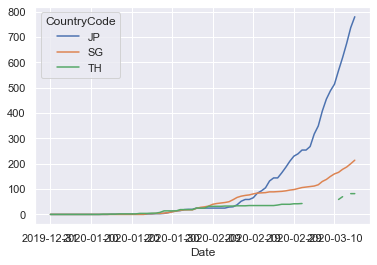

In [4]:
codes = ['SG', 'TH', 'JP']
early_df = df[df['CountryCode'].isin(codes)]
early_confirmed = early_df.pivot(columns='CountryCode', values='Confirmed')
early_confirmed.plot()

As was widely reported, we see that Singapore has kept the outbreak relatively contained, althought we might want to zoom in on the recent steeper incline. Thailand appears to be missing some data, and the news of 3/15/2020 says there's been a sudden jump in confirmed cases. We'll check back on Thailand in a couple days. Meanwhile, let's see if Singapore is still experiencing merely linear growth for the last ten days.

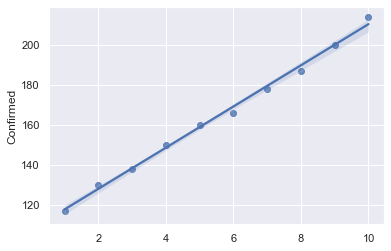

In [5]:
y = df[df['CountryCode'] == 'SG']['Confirmed'].tail(10)
x = np.linspace(1, 10, num=10)
sns.regplot(x,y)

Looks like Singapore has it under control even if there was an increase in the number of new cases per day starting a couple weeks ago. Now let's focus on Japan.

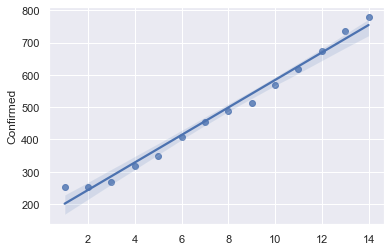

In [6]:
y = df[df['CountryCode'] == 'JP']['Confirmed'].tail(14)
x = np.linspace(1, 14, num=14)
sns.regplot(x,y)

Although Japan has many more cases than Singapore, it also appears to be growing at a roughly linear rate, which is very encouraging. Let's move on to South Korea, which we left out above.

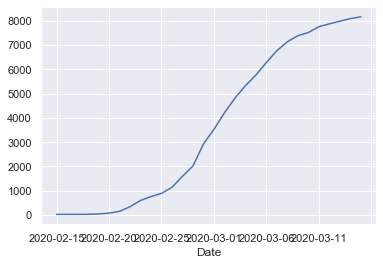

In [7]:
korea_df = df[df['CountryCode'] == 'KR']['Confirmed'].tail(30)
korea_df.plot()

That definitely does not look linear. In fact, the confirmed cases went through a period of apparently exponential growth, but they then leveled off to form the classic logistic curve. Let's see if we can fit the data to that model.

[2.85616878e+02 3.31559481e-01 8.15363539e+03]


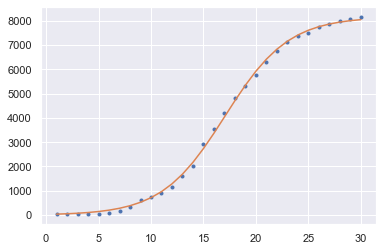

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c):
     y = c / (1 + a*np.exp(-b*x))
     return y

x = np.linspace(1, 30, num=30)
popt, pcov = curve_fit(sigmoid, x, korea_df)
plt.plot(x, korea_df, '.', x, sigmoid(x,*popt), '-')
print(popt)

Now, let's go closer to home for the author: The US. The last 3 weeks has felt very intense, so we'll pay attention to that period.

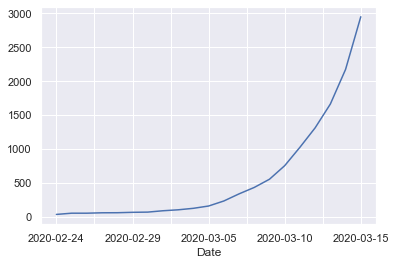

In [9]:
us_df = df[df['CountryCode'] == 'US']['Confirmed']
us_df.tail(21).plot()

Wow! That sure looks like exponential growth. Let's fit an exponential curve and then compare to another country in the midst of a crisis: Italy.

[9.49949942 0.27275969]


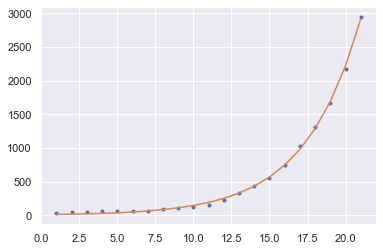

In [10]:
def exponential(x, c, r):
    y = c*np.exp(r*x)
    return y

x = np.linspace(1, 21, num=21)
y = us_df.tail(21)
popt, pcov = curve_fit(exponential, x, y)
plt.plot(x, y, '.', x, exponential(x,*popt), '-')
print(popt)

That's spooky! Let's extrapolate to predict the next week of growth if the social distancing measures currently being suggested don't have the desired effect right away.

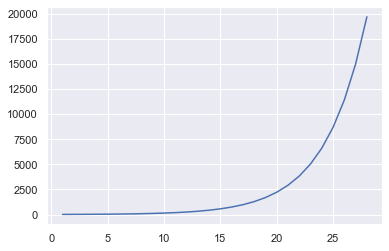

In [11]:
x = np.linspace(1, 28, num=28)
plt.plot(x, exponential(x,*popt), '-')

For reference, let's see how many confirmed cases have shut down Italy and overwhelmed its health care system.

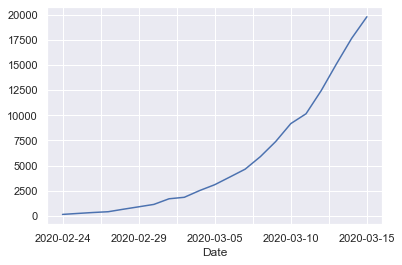

In [12]:
it_df = df[df['CountryCode'] == 'IT']['Confirmed']
it_df.tail(21).plot()

So in just one week, we might be where Italy is now in terms of confirmed cases. Of course, the population, geography, and politics of the US are very different. We'll do more refined comparisons in a future notebook. For now, let's check the parameters of the exponential growth.

[4.43071336e+02 1.83500808e-01]


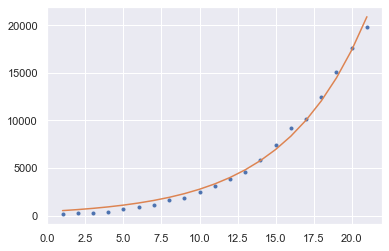

In [13]:
x = np.linspace(1, 21, num=21)
y = it_df.tail(21)
popt, pcov = curve_fit(exponential, x, y)
plt.plot(x, y, '.', x, exponential(x,*popt), '-')
print(popt)

In Italy, it's hard to tell, but the rate may be decreasing slightly while in the US it could be increasing slightly. In addition, the rate of this exponential fit is about 0.1835 while for the US we had about 0.2728 as our rate. For reference, those are doubling times of about 90 hours versus 61 hours, respectively. 

Just for visualization, let's optimistically suppose that thanks to the lockdown in Italy, they're reaching an inflection point in the growth, which means we should use a logistic model to predict the next few weeks. We'll take the current number of cases and assume that the carrying capacity will be about double that, say 40000, and assume we started with about 100 cases three weeks ago. Let's assume that the exponential growth rate is actually about the same as in the US, around 0.28. This gives us a logistic model with $y = \frac{40000}{1 + 399 e^{-0.28x}}$. This is of course very back-of-the-envelope, but it can give us a highly optimistic prediction to compare with data in the next week or so.

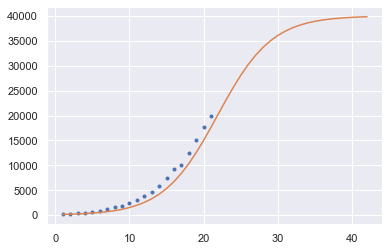

In [14]:
x1 = np.linspace(1, 21, num=21)
y1 = it_df.tail(21)
x2 = np.linspace(1, 42, num=42)
plt.plot(x1, y1, '.', x2, sigmoid(x2,390,0.273,40000), '-')